In [8]:
import numpy as np

from robust_smc.data import LinearTANSimulator
from robust_smc.sampler import LinearDiagonalGaussianBPF

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
simulator = LinearTANSimulator(100, observation_std=20.0, seed=82)

In [3]:
prior_std = np.array([1e-1, 1e-1, 1.0, 1e-2, 1e-2, 1e-1])
process_std = simulator.process_std
transition_matrix = simulator.transition_matrix
observation_matrix = np.eye(3, 6)

In [4]:
T = simulator.Y.shape[0]

In [5]:
pred_m, pred_P = [], []
filter_m, filter_P = [], []
marginal_S = []
filter_m.append(simulator.X0[:, None])
filter_P.append(np.diag(prior_std))
for t in range(T):
    # Prediction Step
    m_bar = np.matmul(transition_matrix, filter_m[-1])
    P_bar = np.matmul(transition_matrix, filter_P[-1])
    P_bar = np.matmul(P_bar, transition_matrix.T) + np.diag(process_std ** 2)
    pred_m.append(m_bar)
    pred_P.append(P_bar)
    
    # Update Step
    v = simulator.Y[t][:, None] - np.matmul(observation_matrix, pred_m[-1])
    S = np.matmul(observation_matrix, pred_P[-1])
    S = np.matmul(S, observation_matrix.T) + (simulator.observation_std ** 2) * np.eye(3)
    
    K = np.matmul(pred_P[-1], observation_matrix.T)
    K = np.matmul(K, np.linalg.inv(S))
    
    m = pred_m[-1] + np.matmul(K, v)
    P = pred_P[-1] - np.matmul(np.matmul(K, S), K.T)
    
    filter_m.append(m)
    filter_P.append(P)
    marginal_S.append(S)

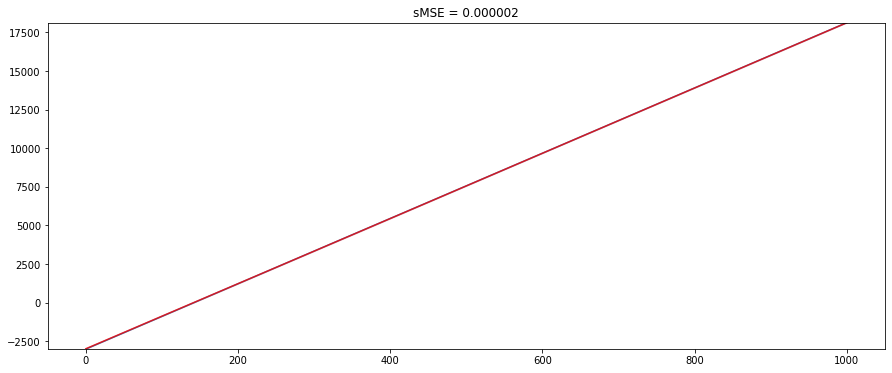

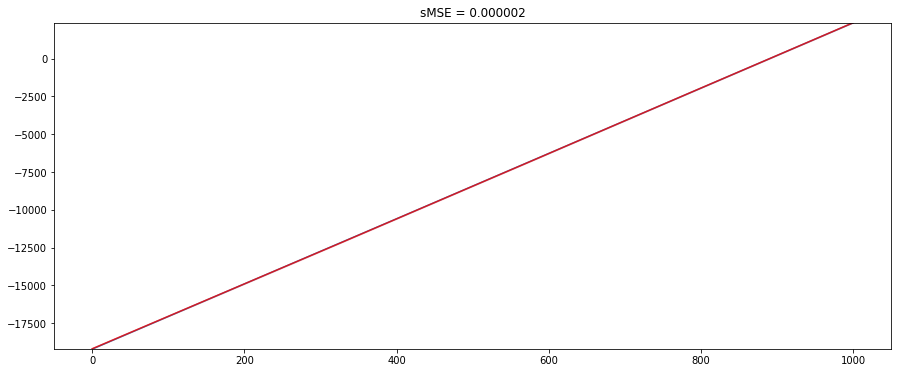

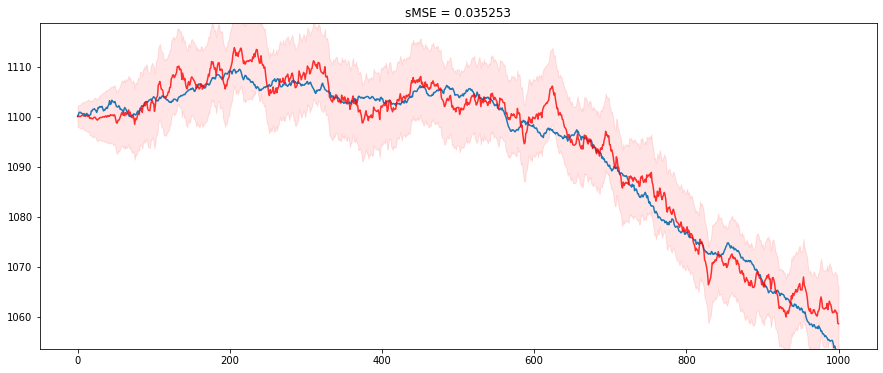

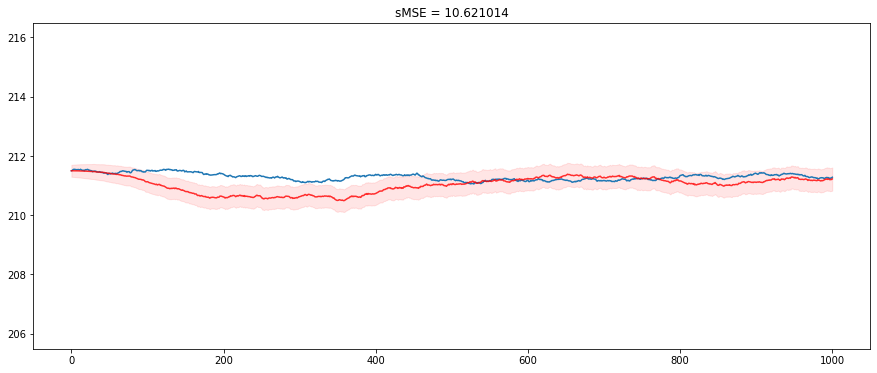

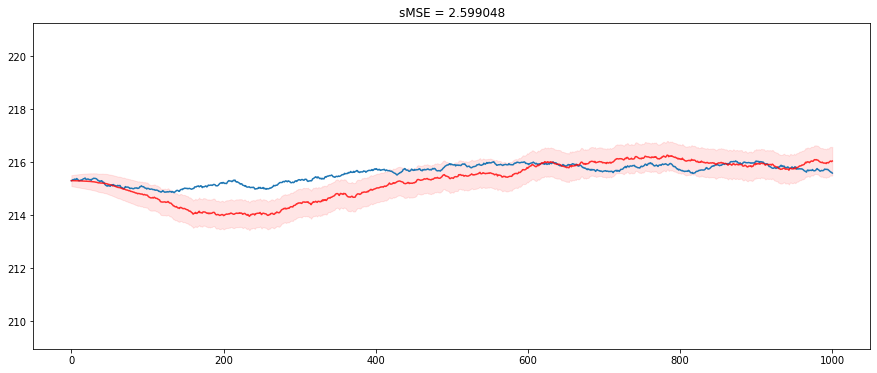

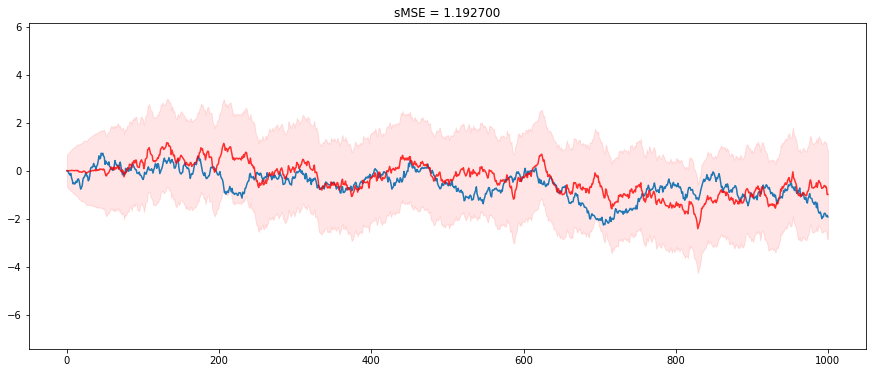

In [11]:
traj = np.stack(filter_m)
uncertainty =  np.stack([np.diagonal(P) for P in filter_P])
for var in range(6):
    plt.figure(figsize=(15, 6))
    plt.plot(simulator.X[:, var])
    mean = traj[1:, var, 0]
    smse = mean_squared_error(simulator.X[:, var], mean) / np.var(simulator.X[:, var])
    std = np.sqrt(uncertainty[1:, var])
    plt.plot(mean, c='r', alpha=0.8, ls='-')
    plt.fill_between(range(1001), mean - 2 * std, mean + 2 * std, color='r', alpha=0.1)
    lims = (np.min(mean), np.max(mean))
    plt.ylim(lims[0] - 5., lims[1] + 5.0)
    plt.title('sMSE = {:4f}'.format(smse))